In [1]:
import glob
import os
import unicodedata
import string
import torch
import random
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers = num_layers,
                            batch_first=False)
        
        self.linear1 = nn.Linear(hidden_size, output_size)
        self.linear2 = nn.Linear(output_size, output_size)
        
        nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.linear2.weight, nonlinearity='relu')
            
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = F.relu(self.linear1(out))
        out = self.linear2(out)
        return out, hidden
    
    def init_hidden(self, batch_size=1):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return h0, c0

In [3]:
# First, retrieve all the book names and collect the contexes in a list
files = glob.glob('books/*.txt')
book_names = []          
all_book_lines = []   

for filename in files:
    book_names.append(os.path.splitext(os.path.basename(filename))[0])
    with open(filename, 'r') as f:
        all_book_lines += f.readlines()

# Put all the chars into a single list
chars = [char for line in all_book_lines for char in line]
v = list(set(chars))  # vocab
n_vocab = len(v)
v_idx = {v[i]:i for i in range(n_vocab)}    # vocab-index dictionary

In [4]:
def str_to_oh(word):
    idxs = torch.tensor([v_idx[l] for l in word])
    oh = F.one_hot(idxs, n_vocab)
    return oh

context_length = 100

In [5]:
# This calculates the indexes essentially twice, 
# can be optimized
def random_tr_set_batch(data, seq_length=32, batch_size=64):
    X_batch = torch.zeros(seq_length, batch_size, n_vocab).float()
    Y_batch = torch.zeros(seq_length, batch_size, dtype=torch.long)
    
    for i in range(batch_size):
        start_idx = random.randint(0, len(data) - seq_length - 1)
        x_list = data[start_idx:start_idx + seq_length]
        y_list = data[start_idx + 1:start_idx + seq_length + 1]

        X_oh = str_to_oh(x_list).type(torch.float32)
        Y_idx = torch.tensor([v_idx[l] for l in y_list])

        X_batch[:, i] = X_oh
        Y_batch[:, i] = Y_idx

    return X_batch, Y_batch

In [6]:
n_hidden = 256
model = LSTM(n_vocab, n_hidden, n_vocab, num_layers=10)
# model.load_state_dict(torch.load('models/model_29.pt'))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
batch_size = 128

writer = SummaryWriter()

In [7]:
for i in tqdm(range(3000)):
    X, y = random_tr_set_batch(chars, seq_length=100, batch_size=batch_size)
    
    h, c = model.init_hidden(batch_size=batch_size)
    # output, (h, c) = model(X, (h, c))
    output, (h, c) = model(X, (h.detach(), c.detach()))

    output = output.view(-1, n_vocab)
    y = y.view(-1)
    loss = loss_fn(output, y)
    # losses.append(loss.item())
    
    writer.add_scalar('Loss/train', loss.detach(), i)
    
    if i % 500 == 0:
        if not os.path.exists('models/'):
            os.makedirs('models/')
        file_name = f'models/model_{str(round(i/100))}.pt'
        torch.save(model.state_dict(), file_name)

    model.zero_grad()
    loss.backward()
    optimizer.step()

 66%|██████▌   | 1985/3000 [26:03<13:03,  1.30it/s]

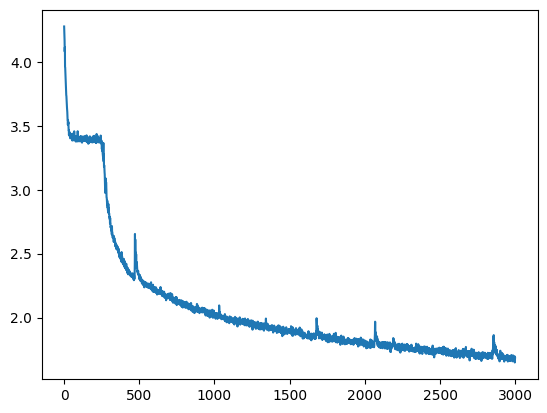

In [ ]:
plt.plot(losses)

# ADD DROPOUT AND REGULARIZATION